<p><b>This python code developed in Ubuntu.<br>Make sure to get installed below python libraries and packages in local system.</b><p>

```
!sudo pip3 install pytesseract
!sudo apt-get install tesseract-ocr
!sudo pip3 install pyocr
!sudo apt-get install python-opencv
!sudo pip3 install scikit-image
!sudo pip3 install PIL
!sudo pip3 install pyttsx3
!sudo pip3 install gtts
!sudo apt-get install espeak
!sudo apt-get install mpg123```

In [1]:
import pyocr
import pyocr.builders
import cv2
from PIL import Image
import os
import numpy as np
from skimage.filters import threshold_local
import matplotlib.pyplot as plt
import pyttsx3
from gtts import gTTS
import subprocess

In [2]:
files_in_dir=os.listdir()

In [3]:
#get image file names in current directory
image_names=[]
conventions=['jpeg','png','jpg']
for file in files_in_dir:
    ext=file.split('.')[-1]
    if ext in conventions:
        image_names.insert(0,file)

In [4]:
image_names

['test.png']

In [5]:
curr_path=os.getcwd()

In [6]:
#Read images into opencv numpy arrays
images_read=[]
for name in image_names:
    img=cv2.imread(name)
    images_read.insert(0,img)

In [7]:
def plot_img(img,is_gray=True):
    fig=plt.figure(figsize=(10,15))
    ax=fig.add_subplot(111)
    cp_img=None
    if is_gray is False:
        cp_img=img.copy()
        cp_img[:,:,0]=img[:,:,2]
        cp_img[:,:,2]=img[:,:,0]
    ax.imshow({True:img,False:cp_img}[is_gray is True],
                cmap={True:'gray',False:None}[is_gray is True])
    plt.xticks([]),plt.yticks([])
    plt.show()

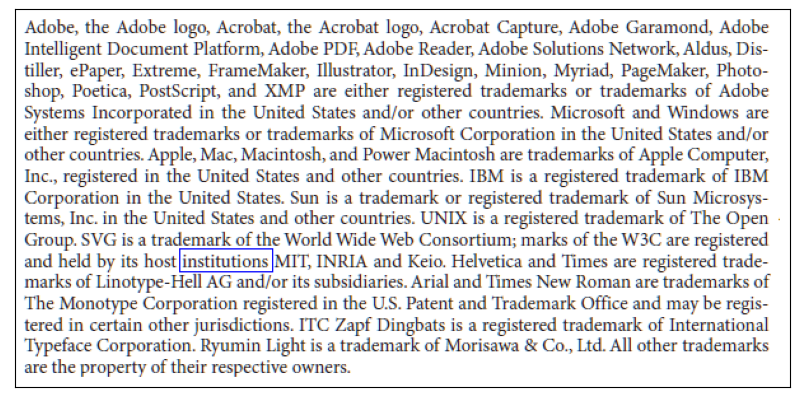

In [8]:
for img in images_read:
    plot_img(img,True)

In [9]:
#Convert RGB images to Gray Scale
thsh_images=[]
for img in images_read:
    img_gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    clahe=cv2.createCLAHE(clipLimit=4.0,tileGridSize=(16,16))
    img_gray=clahe.apply(img_gray)
    ret,th=cv2.threshold(img_gray,130,255,cv2.THRESH_BINARY)
    thsh_images.append(th)

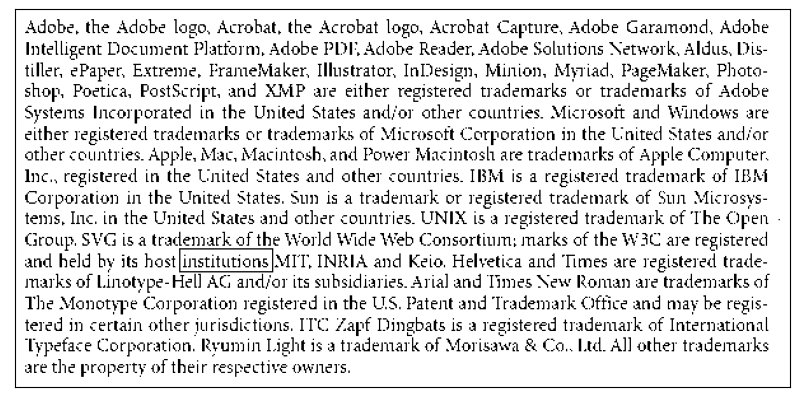

In [10]:
for img in thsh_images:
    plot_img(img)

In [11]:
#Find contours in image using (tree retrival method) for hierarchy
image_conts=[]
for img in thsh_images:
    contours,_=cv2.findContours(img.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    image_conts.append(contours)

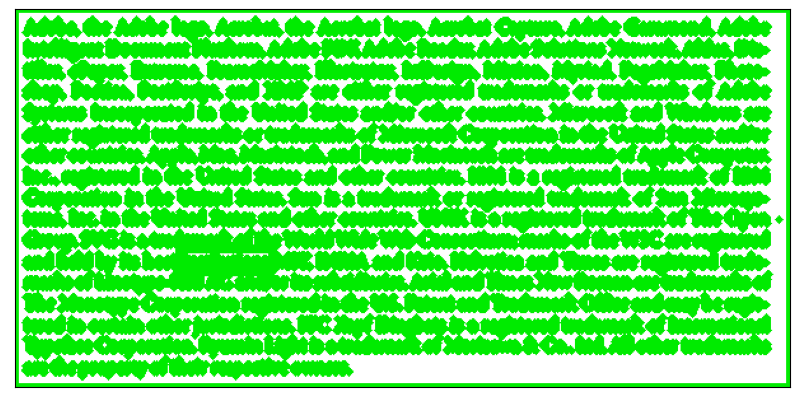

In [12]:
for ind,contour in enumerate(image_conts):
    img=images_read[ind].copy()
    img=cv2.drawContours(img,contour,3,(0,255,0),4)
    plot_img(cv2.drawContours(img,contour,-1,(0,235,0),3),False)

In [13]:
#Look for maximum area contour which describes page/rectangle structure 
#in image
max_area_conts=[]
for contour in image_conts:
    max_ind,max_area=None,0
    for ind,cnt in enumerate(contour):
        area=cv2.contourArea(cnt)
        if area > max_area:
            max_area=area
            max_ind=ind
    max_area_conts.append(max_ind)

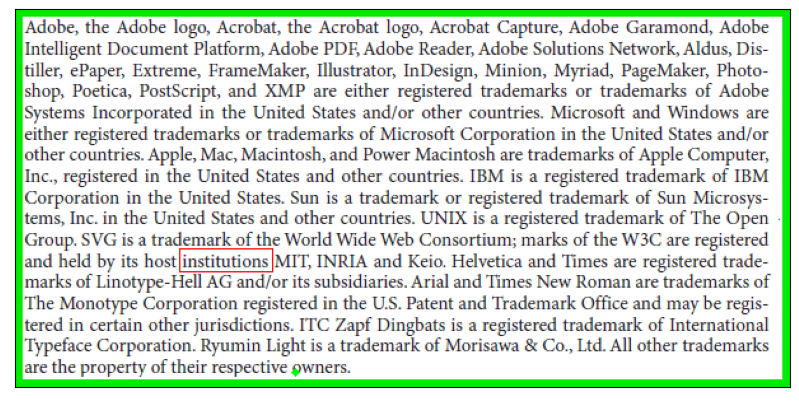

In [14]:
#Fit contour of maximum area
for ind,contour in enumerate(image_conts):
    img=images_read[ind].copy()
    img=cv2.drawContours(img,contour,3,(0,255,0),4)
    plot_img(cv2.drawContours(img,contour,max_area_conts[ind],(0,235,0),10),False)

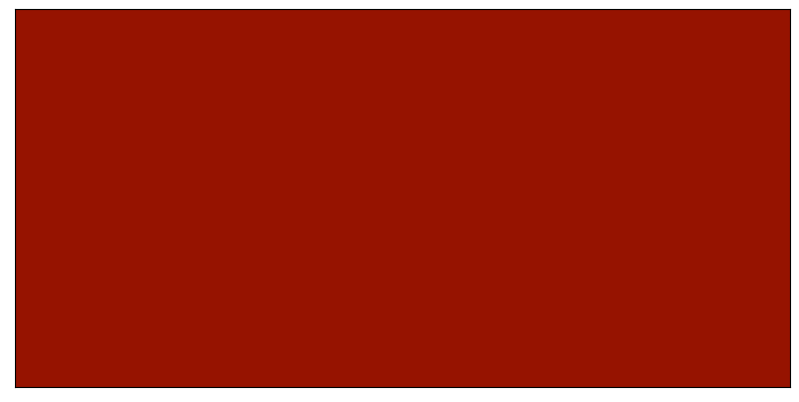

In [15]:
#Draw closest four sided shape around maximum contour which is our 
#area of interest in image
approx_cont=[]
for ind in range(len(images_read)):
    epsilon=0.02*cv2.arcLength(image_conts[ind][max_area_conts[ind]],True)
    approx=cv2.approxPolyDP(image_conts[ind][max_area_conts[ind]],epsilon,True)
    approx_cont.append(np.squeeze(approx))
    im=cv2.drawContours(images_read[ind].copy(),[approx],0,(0,19,150),-1)
    plot_img(im,False)

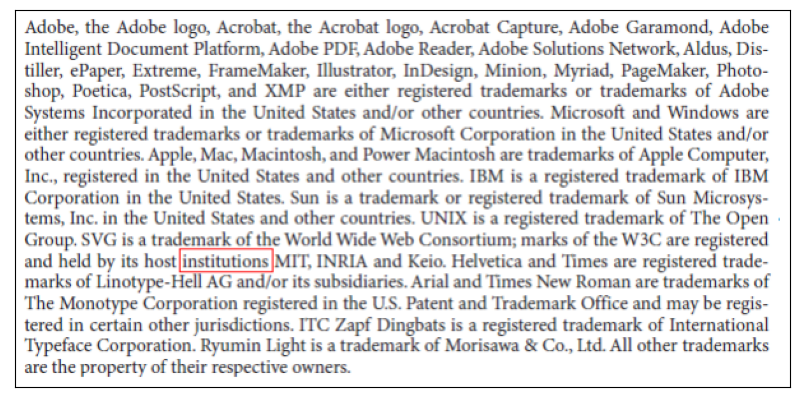

In [16]:
#Take out the four sided area of interest from image and
#project to rectangle shape which is usual shape of an image.
rect_images=[]
for ind in range(len(images_read)):
    #top-left,bottom-left,bottom-right,top-right
    tl,bl,br,tr=approx_cont[ind].tolist()
    top_width=np.sqrt((tl[0]-tr[0])**2 + (tl[1]-tr[1])**2)
    bottom_width=np.sqrt((bl[0]-br[0])**2 + (bl[1]-br[1])**2)
    left_height=np.sqrt((tl[0]-bl[0])**2 + (tl[1]-bl[1])**2)
    right_height=np.sqrt((tr[0]-br[0])**2 + (tr[1]-br[1])**2)
    width=int(max(top_width,bottom_width))
    height=int(max(left_height,right_height))
    #order is tl,tr,br,bl
    pres=np.array([tl,tr,br,bl],dtype='float32')
    to=np.array([[0,0],[width-1,0],[width-1,height-1],[0,height-1]],dtype="float32")
    M=cv2.getPerspectiveTransform(pres,to)
    dst=cv2.warpPerspective(images_read[ind].copy(),M,(int(width),int(height)))
    rect_images.append(dst)
    plot_img(dst,False)

In [17]:
#Digitise image in black and white as a scanned document
digitised_image_names=[]
for ind in range(len(rect_images)):
    img_gray=cv2.cvtColor(rect_images[ind].copy(),cv2.COLOR_BGR2GRAY)
    th=threshold_local(img_gray.copy(),101,offset=10,method="gaussian")
    img_gray=(img_gray>th)
    imgg=Image.fromarray(img_gray)
    size=(images_read[ind].shape[0],images_read[ind].shape[1])
    imgg.resize(size)
    name=curr_path+"/digitised_"+image_names[ind].split('.')[0]+'.jpg'
    digitised_image_names.append(name)
    imgg.save(digitised_image_names[ind])

In [18]:
#Convert all digitised images to pdf format
digitised_images=[]
for name in digitised_image_names:
    imgg=Image.open(name)
    digitised_images.append(imgg)
name=curr_path+"/digitised_images"+'.pdf'
if len(digitised_images)>1:
    digitised_images[0].save(name,save_all=True,append_images=digitised_images[1:],resolution=100.0)
else:
    digitised_images[0].save(name)

In [21]:
#Extract text from image using PyOcr
image_txt=[]
tools=pyocr.get_available_tools()[0]
lang=tools.get_available_languages()[0]
for name in digitised_image_names:
    txt=tools.image_to_string(Image.open(name), \
                              lang=lang,builder=pyocr.builders.TextBuilder())
    txt=' '.join(txt.replace('-\n','').replace('\n',' ').split())
    image_txt.append(txt)
print(image_txt)

['Adobe, the Adobe logo, Acrobat, the Acrobat logo, Acrobat Capture, Adobe Garamond, Adobe Intelligent Document Platform, Adobe PDF, Adobe Reader, Adobe Solutions Network, Aldus, Distiller, ePaper, Extreme, FrameMaker, Illustrator, InDesign, Minion, Myriad, PageMaker, Photoshop, Poetica, PostScript, and XMP are cither registered trademarks or trademarks of Adobe Systems Incorporated in the United States and/or other countries. Microsoft and Windows are either registered trademarks or trademarks of Microsoft Corporation in the United States and/or other countries. Apple, Mac, Macintosh, and Power Macintosh are trademarks of Apple Computer, Inc,, registered in the United States and other countries. IBM is a registered trademark of IBM Corporation in the United States. Sun is a trademark or registered trademark of Sun Microsystems, Inc, in the United States and other countries. UNIX is a registered trademark of The Open Group. SVG is a trademark of the World Wide Web Consortium; marks of 

In [26]:
#Convert text to speech using either Google TextToSpeech(gTTS) or pyttsx3
#gtts requires internet and takes time to upload but smooth voice
#pyttsx3 voice is a bit robotic but work offline
mode='offline'
#mode=input('Online (Requires internet,takes time but smooth voice) or\nOffline (Fast but robotic voice)?\n')
for txt in image_txt:
        try:
            tts=gTTS(text=txt,lang='en')
            tts.save('audio.mp3')
            status=subprocess.Popen(['mpg123','-q','audio.mp3']).wait()
            if(status!=0):
                print("Something went wrong!")
            else:
                print("ok")
        except Exception:
            print("Error Occured,Please Check If Everything OK!")


Error Occured,Please Check If Everything OK!


In [ ]:
#Convert text to speech using either Google TextToSpeech(gTTS) or pyttsx3
#gtts requires internet and takes time to upload but smooth voice
#pyttsx3 voice is a bit robotic but work offline
mode='offline'
mode=input('Online (Requires internet,takes time but smooth voice) or\nOffline (Fast but robotic voice)?\n')
for txt in image_txt:
    if mode.lower()=='online':
        try:
            tts=gTTS(text=txt,lang='en')
            tts.save('audio.mp3')
            status=subprocess.Popen(['mpg123','-q','audio.mp3']).wait()
            if(status!=0):
                print("Something went wrong!")
        except Exception:
            print("Error Occured,Please Check If Everything OK!")
    elif mode.lower()=='offline':
        try:
            engine = pyttsx3.init() 
            engine.setProperty('rate',150)
            engine.say(txt)
            engine.runAndWait()
        except Exception:
            print("Error Occured,Please Check If Everything OK!")
    else:
        print("Couldn\'t resolve mode type")

In [ ]:
#Convert text to speech using either Google TextToSpeech(gTTS) or pyttsx3
#gtts requires internet and takes time to upload but smooth voice
#pyttsx3 voice is a bit robotic but work offline
mode='offline'
mode=input('Online (Requires internet,takes time but smooth voice) or\nOffline (Fast but robotic voice)?\n')
for txt in image_txt:
        try:
            engine = pyttsx3.init() 
            engine.setProperty('rate',150)
            engine.say(txt)
            engine.runAndWait()
        except Exception:
            print("Error Occured,Please Check If Everything OK!")